In [ ]:
# @title Imports

import os
import sys
import cv2
import json
import shutil
import random
import numpy as np
import tensorflow as tf
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from albumentations.augmentations.transforms import RandomSunFlare
from tensorflow.keras import backend as K
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.layers import AveragePooling2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard

print(f'Python: {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}')
print(f'Tensorflow: {tf.__version__}')

Python: 3.8.16
Tensorflow: 2.9.2


In [ ]:
# @title Upload templates for data augmentation

!rm -rf ./datasets
!rm ./datasets.zip
!wget https://www.dropbox.com/s/b4z9x8pblj93u3c/datasets.zip
!unzip -o datasets.zip

rm: cannot remove './datasets.zip': No such file or directory
--2022-12-12 14:36:48--  https://www.dropbox.com/s/b4z9x8pblj93u3c/datasets.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/b4z9x8pblj93u3c/datasets.zip [following]
--2022-12-12 14:36:48--  https://www.dropbox.com/s/raw/b4z9x8pblj93u3c/datasets.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9cd2db2c9b4a23d078a09b75c3.dl.dropboxusercontent.com/cd/0/inline/ByeOHxIs5sVaAzbKQG3RBL5zBz6RIv2i93HI5dhadr5uRtynHh8l6Pf0OrElVFx1-9U8Wd0rV_gutbGjKbtEnnNlLs90jrU0RwomaIKcrX0Lb8IOh1l8lWNhiEXjaysKneoeA6UlwxJZk-ejCLl6zJo2N7Zmp-oR0x_xpNe6584CxA/file# [following]
--2022-12-12 14:36:49--  https://uc9cd2db2c9b4a23d078a09b75c3.dl.dropboxusercontent.com/cd/0/inline/ByeOHxIs5sVaAzbKQG

In [ ]:
# @title Data augmentation - Config

# Woring directory
WORK_DIR = '/content/datasets'

# Path to structure dataset file
STRUCTURE_PATH = f'{WORK_DIR}/structure.json'

# Maximum image size
MAX_IMAGE_SIZE = 512

# Resizing
MIN_RESIZE_PERCENTAGES = 20
MAX_RESIZE_PERCENTAGES = 100
STEP_RESIZE_PERCENTAGES = 20

# Rotation
STEP_ROTATE_DEGREES = 6

# Perspective
PERSPECTIVE_THRESHOLD = 0.3

In [ ]:
# @title Generate datasets - Utils methods


# Read dataset structure file
def get_structure():
    with open(STRUCTURE_PATH) as infile:
        json_data = json.load(infile)
    return json_data


# Draw points on image and present it
def draw_image(image, image_points):
    plt.imshow(image) 
    
    for point in image_points:
        plt.scatter(point[0], point[1], color='red')

    plt.show()
    

# Recreate "/images" and "/masks" in dataset working directory
def create_dirs():
    images_dir = WORK_DIR + '/images/'
    masks_dir = WORK_DIR + '/masks/'
    
    if os.path.exists(images_dir):
        shutil.rmtree(images_dir)
        
    os.makedirs(images_dir)
        
    if os.path.exists(masks_dir):
        shutil.rmtree(masks_dir)
        
    os.makedirs(masks_dir)
    

# Get 2D gradient
def get_gradient_2d(start, stop, width, height, is_horizontal):
    if is_horizontal:
        return np.tile(np.linspace(start, stop, width), (height, 1))
    else:
        return np.tile(np.linspace(start, stop, height), (width, 1)).T


# Get 3D gradient
def get_gradient_3d(width, height, start_list, stop_list, is_horizontal_list):
    result = np.zeros((height, width, len(start_list)), dtype=np.float32)

    for i, (start, stop, is_horizontal) in enumerate(zip(start_list, stop_list, is_horizontal_list)):
        result[:, :, i] = get_gradient_2d(start, stop, width, height, is_horizontal)

    return result    
    
    
# Get the most used colors in image (count = 32)
def get_image_colors(img):
    image = img.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128), interpolation=cv2.INTER_AREA)

    (h, w, c) = img.shape

    img2D = img.reshape(h * w, c)
    kmeans = KMeans(n_clusters=32).fit(img2D)
    colors = kmeans.cluster_centers_.round(0).astype(int)
    
    return colors.tolist()  


# Shift image
def shift_image(X, dx, dy):
    X = np.roll(X, dy, axis = 0)
    X = np.roll(X, dx, axis = 1)
    
    if dy > 0:
        X[:dy, :] = 0
    elif dy < 0:
        X[dy:, :] = 0
    if dx > 0:
        X[:, :dx] = 0
    elif dx < 0:
        X[:, dx:] = 0
    return X


# Get list of background files
def get_backgrounds():
    return glob(f"{WORK_DIR}/backgrounds/*")


# Random noise for image
def add_random_noise(img):
    if (bool(random.getrandbits(1))):
        return img
    
    random_value = random.randint(0, 50)
    
    if (random_value == 0):
        return img
    
    random_value /= 100
    
    gauss = np.random.normal(0, random_value, img.size)
    gauss = gauss.reshape(img.shape[0], img.shape[1], img.shape[2]).astype('uint8')
    noise = img + img * gauss
    
    return noise


# Random shift of images colors
def random_shift_image_colors(img):
    if (bool(random.getrandbits(1))):
        return img
    
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    
    return np.dstack((
        np.roll(R, random.randint(-5, 5), axis=0), 
        np.roll(G, random.randint(-5, 5), axis=1), 
        np.roll(B, random.randint(-5, 5), axis=0)
    ))


# Random sun flare
def random_sun_flare(img):
    if (bool(random.getrandbits(1))):
        return img
    
    flare_roi=(0, 0, 1, 0.5)
    angle_lower=0
    angle_upper=1
    num_flare_circles_lower=6
    num_flare_circles_upper=10
    src_radius=200
    src_color=(255, 255, 255)

    transform = RandomSunFlare(flare_roi, angle_lower, angle_upper, num_flare_circles_lower, num_flare_circles_upper, src_radius, src_color,  p=1.0)

    return transform(image=img)['image']


# Draw random stripes on image
def draw_random_stripes_image():
    img = np.ones((512, 512, 3), np.uint8) * random.randint(0, 255)
    count = random.randint(1, 10)
    
    for i in range(0, count):
        width = random.randint(1, 100)
        position = random.randint(0, 512 - width)        
        start_point = (position, 0)
        end_point = (position + width, 512)
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        thickness = -1
        
        img = cv2.rectangle(img, start_point, end_point, color, thickness)
    
    return img


# Prepare random background
def get_background(colors):
    # Define random mode for create background
    mode = random.choice([1, 2, 3, 4, 5, 6])
    
    # Random gradient
    if (mode == 1):
        background = get_gradient_3d(512, 512, (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)), (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)), (bool(random.getrandbits(1)), bool(random.getrandbits(1)), bool(random.getrandbits(1))))
        background.astype(np.uint8)
        
    # Random gradient using related colors
    elif (mode == 2):
        color1 = random.choice(colors)
        color2 = random.choice(colors)
        background = get_gradient_3d(512, 512, (color1[0], color1[1], color1[2]), (color2[0], color2[1], color2[2]), (bool(random.getrandbits(1)), bool(random.getrandbits(1)), bool(random.getrandbits(1))))
        background.astype(np.uint8)
        
    # White background
    elif (mode == 3):
        background = np.ones((MAX_IMAGE_SIZE, MAX_IMAGE_SIZE, 3), np.uint8) * 255
        
    # Black background
    elif (mode == 4):
        background = np.zeros((MAX_IMAGE_SIZE, MAX_IMAGE_SIZE, 3), np.uint8)
        
    # Random stripe background
    elif (mode == 5):
        background = draw_random_stripes_image()
        
    # Custom background
    else:
        background_path = random.choice(backgrounds)
        background = cv2.imread(background_path)
    
    # Random rotate background
    degree = random.choice([0, 90, 180, 270])
    background = rotate_image_by_percent(background, 50, degree)
    
    return background


# Merge document image with background
def merge_images(image, background):    
    image_width = image.shape[1]
    image_height = image.shape[0]
    
    background_width = background.shape[1]
    background_height = background.shape[0]
    
    # Position by center
    x_offset = int((background_width - image_width) / 2)
    y_offset = int((background_height - image_height) / 2)
    
    y1, y2 = y_offset, y_offset + image_height
    x1, x2 = x_offset, x_offset + image_width
    
    try:
        alpha_image = np.array(image)[:, :, 3] / 255.0
        alpha_background = 1.0 - alpha_image

        for c in range(0, 3):
            background[y1:y2, x1:x2, c] = (alpha_image * image[:, :, c] + alpha_background * background[y1:y2, x1:x2, c])
    except:
        print("merge_images(): Exception occurred")
    
    return background


# Resize image by percent size
def resize_image_by_percent(img, percent):
    img_height, img_width = img.shape[:2]
    ratio = percent / 100
    new_img_width = int(img_width * ratio)
    new_img_height = int(img_height * ratio)
    
    img = cv2.resize(img, (new_img_width, new_img_height), interpolation=cv2.INTER_AREA)
    
    new_img_height, new_img_width = img.shape[:2]
    
    # Center position
    left = int((MAX_IMAGE_SIZE - new_img_width) / 2)
    right = MAX_IMAGE_SIZE - new_img_width - left
    top = int((MAX_IMAGE_SIZE - new_img_height) / 2)
    bottom = MAX_IMAGE_SIZE - new_img_height - top
    
    if left < 0:
        left = 0
    if right < 0:
        right = 0
    if top < 0:
        top = 0
    if bottom < 0:
        bottom = 0
    
    # Add transparent border for saving max image size
    img = cv2.copyMakeBorder(img, top, bottom, left, right, borderType=cv2.BORDER_CONSTANT, value=(255, 255, 255, 0))
    
#     img = add_random_perspective(img, new_img_width, new_img_height)
    
    return img, new_img_width, new_img_height


# Add random persspective
def add_random_perspective(img, width, height):    
    threshhold = int(min(width, height) * PERSPECTIVE_THRESHOLD)
    size_diff = MAX_IMAGE_SIZE - max(width, height)
    
    if threshhold > size_diff:
#         print('Skip perspective: ', threshhold, size_diff)
        return img
    
    src = np.array([
        [0, 0], 
        [MAX_IMAGE_SIZE, 0], 
        [0, MAX_IMAGE_SIZE], 
        [MAX_IMAGE_SIZE, MAX_IMAGE_SIZE]
    ], dtype=np.float32)
    dst = np.array([
        [random.randint(-threshhold, threshhold), random.randint(-threshhold, threshhold)], 
        [MAX_IMAGE_SIZE + random.randint(-threshhold, threshhold), random.randint(-threshhold, threshhold)], 
        [random.randint(-threshhold, threshhold), MAX_IMAGE_SIZE + random.randint(-threshhold, threshhold)], 
        [MAX_IMAGE_SIZE + random.randint(-threshhold, threshhold), MAX_IMAGE_SIZE + random.randint(-threshhold, threshhold)]
    ], dtype=np.float32)
    
    M = cv2.getPerspectiveTransform(src, dst)
    img = cv2.warpPerspective(img, M, (MAX_IMAGE_SIZE, MAX_IMAGE_SIZE), flags=cv2.INTER_LINEAR)
    
    return img


# Crop image
def crop_image(img):
    height, width = img.shape[:2]
    
    x_offset = int((width - MAX_IMAGE_SIZE) / 2)
    y_offset = int((height - MAX_IMAGE_SIZE) / 2)
    
    crop_img = img[y_offset:MAX_IMAGE_SIZE - y_offset, x_offset:MAX_IMAGE_SIZE - x_offset]

    return crop_img


# Rotate image
def rotate_image_by_percent(image, percent, angle):
    if angle == 0:
        return image
    
    height, width = image.shape[:2]
    avalilable_angle = (100 - percent + 1) * 4.5
    
    if avalilable_angle >= 45:
        avalilable_angle = 360
        
    if angle > avalilable_angle and angle % 45 != 0:
        return None
    
    center_x, center_y = (width / 2, height / 2)
    M = cv2.getRotationMatrix2D((center_x, center_y), angle, 1.0)

    return cv2.warpAffine(image, M, (width, height))


# Save image
def save_image(image, image_counter):
    new_img_path = WORK_DIR + '/images/' + str(image_counter) + '.jpg'
    
    cv2.imwrite(new_img_path, image)
    
    
# Save mask
def save_mask(image, color, image_counter):
    new_img_path = WORK_DIR + '/masks/' + str(image_counter) + '.png'
    
    img = image.copy()
    
    # Object color
    mask = (img != [255, 255, 255, 0]).all(axis = 2)
    img[mask] = [color, color, color, 255]
    
    # Black background
    mask = (img != [color, color, color, 255]).all(axis = 2)
    img[mask] = [0, 0, 0, 255]
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(new_img_path, gray)


# Random blurring
def add_bluring(img):
    sigma = random.randint(0, 6)
    
    if sigma > 0 and sigma % 2 == 1:
        img = cv2.GaussianBlur(img, (sigma, sigma), 0)
        
    return img
    
    
# Random gamma correction
def add_gamma(image):
   gamma = random.randint(3, 13) / 10
   table = np.array([
      ((i / 255.0) ** gamma) * 255
      for i in np.arange(0, 256)])
   return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))
    
    
# Random position
def set_random_position(img, size_percentage):    
    max_size = int(MAX_IMAGE_SIZE * (size_percentage / 100))
    offset = MAX_IMAGE_SIZE - max_size
    
    if (offset > 0):
        min_offset = -int(offset / 2)
        max_offset = int(offset / 2)
        x_offset = random.randint(min_offset, max_offset)
        y_offset = random.randint(min_offset, max_offset)
        
        img = shift_image(img, x_offset, y_offset)
        
    return img

In [ ]:
# @title Generate datasets - Genarate dataset images and masks

create_dirs()
structure = get_structure()
backgrounds = get_backgrounds()

print('Structure: ', structure)
print('Backgrounds: ', backgrounds)
    
image_counter = 0
image_template_index = 0
# Templates iterator
for item in structure:
    image_template_index += 1
    image_path = item['image']
    image_color = item['color']
    
    print('Prepare dataset for template: ', image_path)

    # Read template
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    
#     plt.imshow(img, aspect='auto')
#     plt.show()
    
    (img_height, img_width, chanels) = img.shape
    img_ratio = img_height / img_width

    # Define new image size
    if (img_ratio < 1):
        new_img_width = MAX_IMAGE_SIZE
        new_img_height = int(MAX_IMAGE_SIZE * img_ratio)
    else:
        new_img_width = int(MAX_IMAGE_SIZE * img_ratio)
        new_img_height = MAX_IMAGE_SIZE

    if (image_counter + 1) % 100 == 0:
        print(f'Image {image_path}: {img_width}x{img_height} ({img_ratio})')

    # Resize image
    img = cv2.resize(img, (new_img_width, new_img_height), interpolation=cv2.INTER_AREA)
    img_width = new_img_width
    img_height = new_img_height
    
    # Get the most use image colors
    image_colors = get_image_colors(img)
    
    # Resize
    for size_percentage in range(MIN_RESIZE_PERCENTAGES, MAX_RESIZE_PERCENTAGES + 1, STEP_RESIZE_PERCENTAGES): 
        resized_img, resized_img_width, resized_img_height = resize_image_by_percent(img, size_percentage)
        
        # Rotate
        for angle in range(0, 359, STEP_ROTATE_DEGREES):  
            # Perspective
            resized_img_with_perspective = add_random_perspective(resized_img, resized_img_width, resized_img_height)
            
            # Rotate
            rotated_img = rotate_image_by_percent(resized_img_with_perspective, size_percentage, angle)
    
            if rotated_img is None:
                continue
            
            # Random position
            rotated_img = set_random_position(rotated_img, size_percentage)
            
            # Save mask
            save_mask(rotated_img, image_color, image_counter)
            
            # Get background
            background = get_background(image_colors)
        
            # Merge with background
            new_img = merge_images(rotated_img, background)
            
             # Shift image colors
            new_img = random_shift_image_colors(new_img)
            
            # Noise
            new_img = add_random_noise(new_img)
            
            if new_img is None:
                continue
                
            # Blur effect
            new_img = add_bluring(new_img)
            
            # Gamma correction
            new_img = add_gamma(new_img)
            
            # Sun flare
            new_img = random_sun_flare(new_img)
            
            print(f'[{image_template_index}/{len(structure)}][{image_counter + 1}] Image: resize={size_percentage}%, rotate={angle}°')
            
            # Save image
            save_image(new_img, image_counter)
            image_counter += 1

Structure:  [{'image': '/content/datasets/sources/kz-drivers-license-1-front-side.png', 'color': 1}, {'image': '/content/datasets/sources/kz-e-passport-front-side.png', 'color': 1}, {'image': '/content/datasets/sources/kz-identity-card-1-back-side.png', 'color': 1}, {'image': '/content/datasets/sources/kz-identity-card-1-front-side.png', 'color': 1}, {'image': '/content/datasets/sources/kz-identity-card-back-side.png', 'color': 1}, {'image': '/content/datasets/sources/kz-identity-card-front-side.png', 'color': 1}, {'image': '/content/datasets/sources/kz-residence-permit-back-side.png', 'color': 1}, {'image': '/content/datasets/sources/kz-residence-permit-front-side.png', 'color': 1}, {'image': '/content/datasets/sources/ua-drivers-license-1.png', 'color': 1}, {'image': '/content/datasets/sources/ua-drivers-license-2.png', 'color': 1}, {'image': '/content/datasets/sources/ua-drivers-license-3.png', 'color': 1}, {'image': '/content/datasets/sources/ua-e-passport-1.png', 'color': 1}, {'im

In [ ]:
# @title Data augmentation - Spliting of dataset to train, validate and test

TEST_COUNT = 10
TRAIN_COUNT_PERCENT = 0.8
VALIDATE_COUNT_PERCENT = 0.2

count_classes = len(structure)
count_images_per_class = int(image_counter / count_classes)

print(f'Count of classes (templates): {count_classes}')
print(f'Count of images: {image_counter} ({count_images_per_class} images per class)')

# Path for train, validate and test folders
train_dir = WORK_DIR + '/train'
validate_dir = WORK_DIR + '/validate'
test_dir = WORK_DIR + '/test'

# Recreate directory
def recreate_dir(path):
    if os.path.exists(path):
        shutil.rmtree(path)

    os.makedirs(path)

# Recreate train, validate and test directories
recreate_dir(train_dir + '/images')
recreate_dir(train_dir + '/masks')
recreate_dir(validate_dir + '/images')
recreate_dir(validate_dir + '/masks')
recreate_dir(test_dir + '/images')
recreate_dir(test_dir + '/masks')

# Sorting of images and masks
images = sorted(glob(WORK_DIR + '/images/*.jpg'))
masks = sorted(glob(WORK_DIR + '/masks/*.png'))

# Define count of each category
all_count = len(images) - TEST_COUNT
train_count = int(all_count * TRAIN_COUNT_PERCENT)
validate_count = int(all_count * VALIDATE_COUNT_PERCENT)

# Random sorting of images and masks
seed_value = random.randint(1, 100)

random.seed(seed_value)
random.shuffle(images)

random.seed(seed_value)
random.shuffle(masks)

# Split images for train
print(f'Train: {train_count} ({0} => {train_count})')
for i in range(0, train_count):
    shutil.copy2(images[i], train_dir + '/images')    
    shutil.copy2(masks[i], train_dir + '/masks')

# Split images for validate
print(f'Validate: {train_count + validate_count - train_count} ({train_count} => {train_count + validate_count})')
for i in range(train_count, train_count + validate_count):
    shutil.copy2(images[i], validate_dir + '/images')
    shutil.copy2(masks[i], validate_dir + '/masks')

# Split images for test
print(f'Test: {train_count + validate_count + TEST_COUNT - train_count - validate_count} ({train_count + validate_count} => {train_count + validate_count + TEST_COUNT})')
for i in range(train_count + validate_count, train_count + validate_count + TEST_COUNT):
    shutil.copy2(images[i], test_dir + '/images')
    shutil.copy2(masks[i], test_dir + '/masks')

Count of classes (templates): 18
Count of images: 4392 (244 images per class)
Train: 3505 (0 => 3505)
Validate: 876 (3505 => 4381)
Test: 10 (4381 => 4391)


In [ ]:
# @title Create DeepLabV3+ model
# URL: https://arxiv.org/pdf/1606.00915v2.pdf

# Build Atrous Spatial Pyramid Pooling
def ASPP(inputs):
    shape = inputs.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name='bn_1')(y_pool)
    y_pool = Activation('relu', name='relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)

    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y


# Build DeepLabV3+
def DeepLabV3Plus(shape):
    """ Inputs """
    inputs = Input(shape)

    """ Pre-trained ResNet50 """
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    """ Pre-trained ResNet50 Output """
    image_features = base_model.get_layer('conv4_block6_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    """ Get low-level features """
    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)

    """ Outputs """
    x = Conv2D(1, (1, 1), name='output_layer')(x)
    x = Activation('sigmoid')(x)

    """ Model """
    model = Model(inputs=inputs, outputs=x)

    return model


# Intersection over Union (IoU) 
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)


# Dice Coefficient
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)


# Dice loss function 
def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)


# Create model
input_shape = (512, 512, 3)
model = DeepLabV3Plus(input_shape)
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [ ]:
# @title Prepare train data


# Load data
def load_data(path):
    x = sorted(glob(os.path.join(path, "images", "*jpg")))[:2500]
    y = sorted(glob(os.path.join(path, "masks", "*png")))[:2500]
    return x, y


# Read image file
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x/255.0
    x = x.astype(np.float32)
    return x


# Read mask file
def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x


# TF parser
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([MAX_IMAGE_SIZE, MAX_IMAGE_SIZE, 3])
    y.set_shape([MAX_IMAGE_SIZE, MAX_IMAGE_SIZE, 1])
    return x, y


# Create TF dataset
def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset


# Seeding
np.random.seed(1)
tf.random.set_seed(1)


# Recreate directory for storing files
recreate_dir("files")


# Model parameters
batch_size = 2
lr = 1e-4
model_path = os.path.join("files", "model.h5")
csv_path = os.path.join("files", "data.csv")


# Dataset
dataset_path = "/content/datasets"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "validate")

print('train_path = ', train_path)
print('valid_path = ', valid_path)

# Load train and validate data
train_x, train_y = load_data(train_path)
valid_x, valid_y = load_data(valid_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

# Create train and validate dataset
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

print(train_dataset)
print(valid_dataset)

train_path =  /content/datasets/train
valid_path =  /content/datasets/validate
Train: 2500 - 2500
Valid: 876 - 876
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None))>


In [ ]:
# @title Train model

# Train config
num_epochs = 5
model_path = "./files/model.h5"
csv_path = "./files/data.csv"


# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=dice_loss,
    metrics=[dice_coef, iou, Recall(), Precision()]
)

''' 
Callbacks:
  ModelCheckpoint - Callback to save the Keras model or model weights at some frequency.
  ReduceLROnPlateau - Reduce learning rate when a metric has stopped improving.
  CSVLogger - Callback that streams epoch results to a CSV file.
  TensorBoard - Enable visualizations for TensorBoard.
  EarlyStopping - Stop training when a monitored metric has stopped improving.
'''
callbacks = [
    ModelCheckpoint(model_path, verbose = 1, save_best_only = True),
    ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, min_lr = 1e-7, verbose = 1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=False),
]


# Train model
model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Epoch 1/5
1250/1250 [==============================] - ETA: 0s - loss: 0.0916 - dice_coef: 0.9084 - iou: 0.8592 - recall: 0.9481 - precision: 0.9417
Epoch 1: val_loss improved from inf to 0.09716, saving model to ./files/model.h5
1250/1250 [==============================] - 325s 244ms/step - loss: 0.0916 - dice_coef: 0.9084 - iou: 0.8592 - recall: 0.9481 - precision: 0.9417 - val_loss: 0.0972 - val_dice_coef: 0.9028 - val_iou: 0.8397 - val_recall: 0.8912 - val_precision: 0.9351 - lr: 1.0000e-04
Epoch 2/5
1250/1250 [==============================] - ETA: 0s - loss: 0.0232 - dice_coef: 0.9768 - iou: 0.9575 - recall: 0.9794 - precision: 0.9859
Epoch 2: val_loss improved from 0.09716 to 0.03584, saving model to ./files/model.h5
1250/1250 [==============================] - 305s 244ms/step - loss: 0.0232 - dice_coef: 0.9768 - iou: 0.9575 - recall: 0.9794 - precision: 0.9859 - val_loss: 0.0358 - val_dice_coef: 0.9642 - val_iou: 0.9397 - val_recall: 0.9478 - val_precision: 0.9811 - lr: 1.0000e

In [ ]:
# @title Tensorboard
%load_ext tensorboard
%tensorboard --logdir '/content/logs/train'

Test: 10 - 10


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


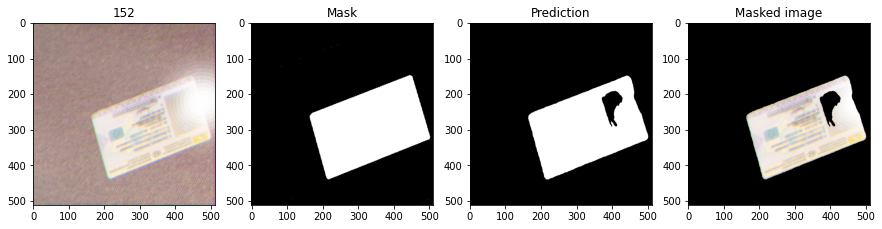

 10%|█         | 1/10 [00:02<00:26,  2.89s/it]

1/1 [==============================] - 0s 42ms/step


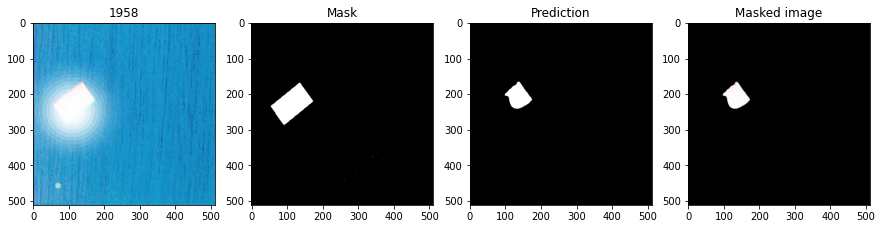

 20%|██        | 2/10 [00:03<00:14,  1.81s/it]

1/1 [==============================] - 0s 78ms/step


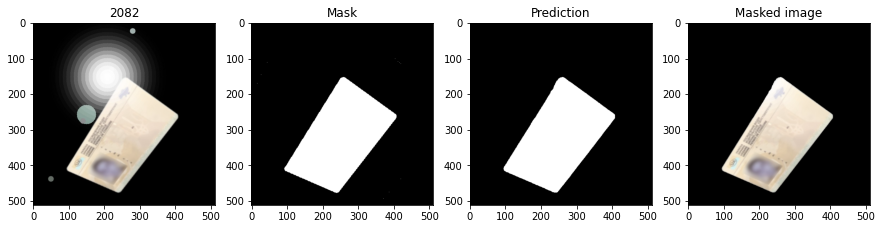

 30%|███       | 3/10 [00:05<00:10,  1.56s/it]

1/1 [==============================] - 0s 38ms/step


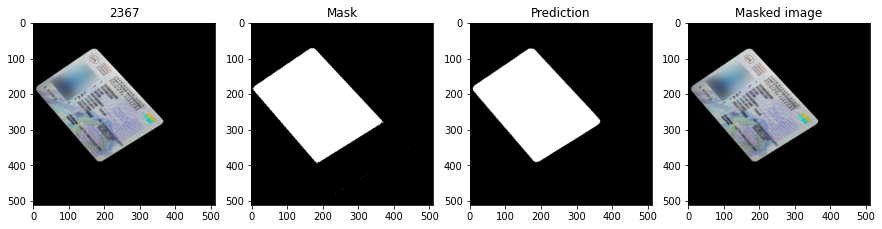

 40%|████      | 4/10 [00:06<00:08,  1.44s/it]

1/1 [==============================] - 0s 55ms/step


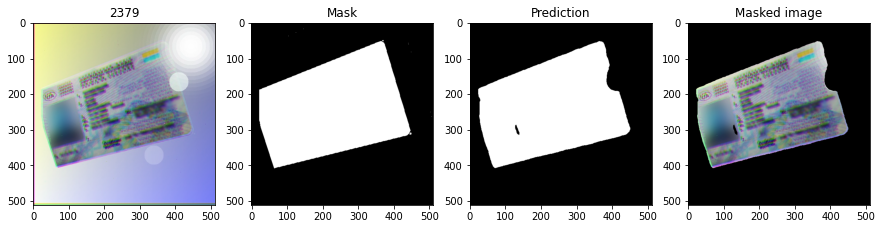

 50%|█████     | 5/10 [00:07<00:06,  1.33s/it]

1/1 [==============================] - 0s 47ms/step


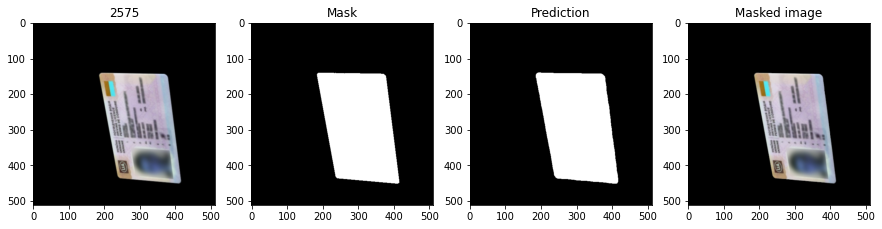

 60%|██████    | 6/10 [00:08<00:05,  1.27s/it]

1/1 [==============================] - 0s 52ms/step


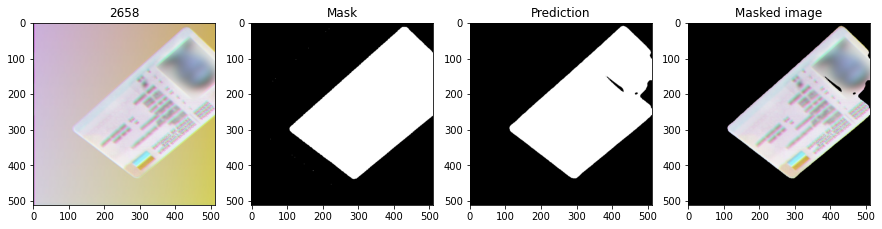

 70%|███████   | 7/10 [00:09<00:03,  1.21s/it]

1/1 [==============================] - 0s 44ms/step


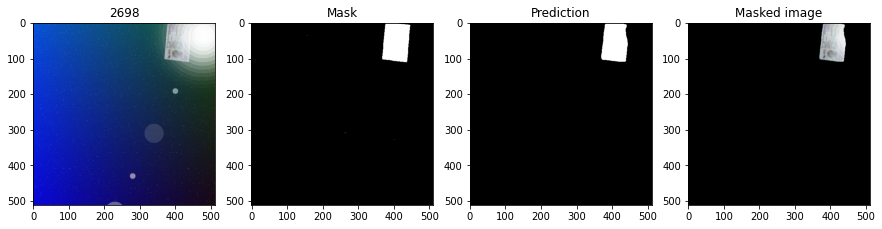

 80%|████████  | 8/10 [00:11<00:02,  1.43s/it]

1/1 [==============================] - 0s 66ms/step


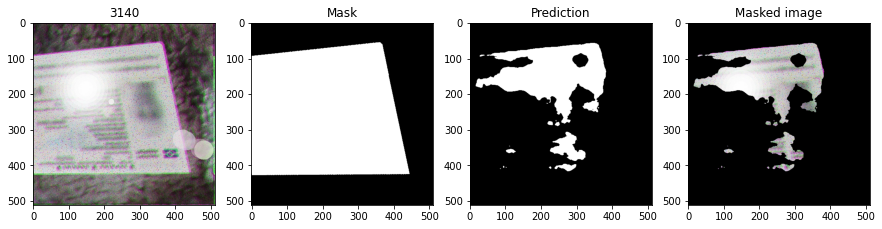

 90%|█████████ | 9/10 [00:13<00:01,  1.43s/it]

1/1 [==============================] - 0s 44ms/step


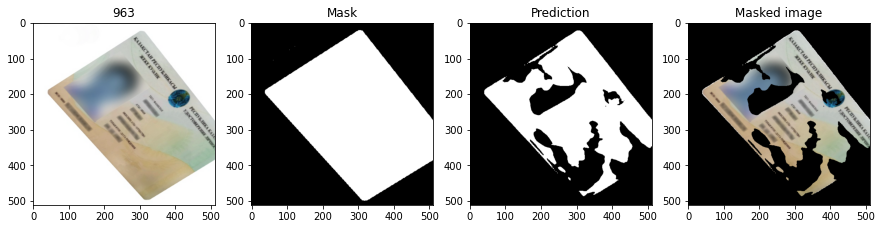

100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


In [ ]:
# @title Evaluate test dataset

# Load model
with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
    model = tf.keras.models.load_model("./files/model.h5")


# Load test dataset
test_x, test_y = load_data('/content/datasets/test')
print(f"Test: {len(test_x)} - {len(test_y)}")


# Present result
def present_results(name, image, mask, y_pred):
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    mask = mask * 255

    y_pred = np.expand_dims(y_pred, axis=-1)    ## (512, 512, 1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)  ## (512, 512, 3)

    masked_image = image * y_pred
    y_pred = y_pred * 255
    
    # Prepare subplots
    _, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 13))

    axes[0].imshow(image)
    axes[0].title.set_text(name)

    axes[1].imshow(mask)
    axes[1].title.set_text('Mask')

    axes[2].imshow(y_pred)
    axes[2].title.set_text('Prediction')

    axes[3].imshow(masked_image)
    axes[3].title.set_text('Masked image')

    plt.show()


# Predict each test image
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    # Extract the name
    name = x.split("/")[-1].split(".")[0]

    # Reading the image
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    x = image/255.0
    x = np.expand_dims(x, axis=0)

    # Reading the mask
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)

    # Prediction
    y_pred = model.predict(x)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)

    # Present result
    present_results(name, image, mask, y_pred)

  0%|          | 0/8 [00:00<?, ?it/s]

2. ratio =  0.7492163009404389 , width =  383 , height =  512
1/1 [==============================] - 1s 833ms/step


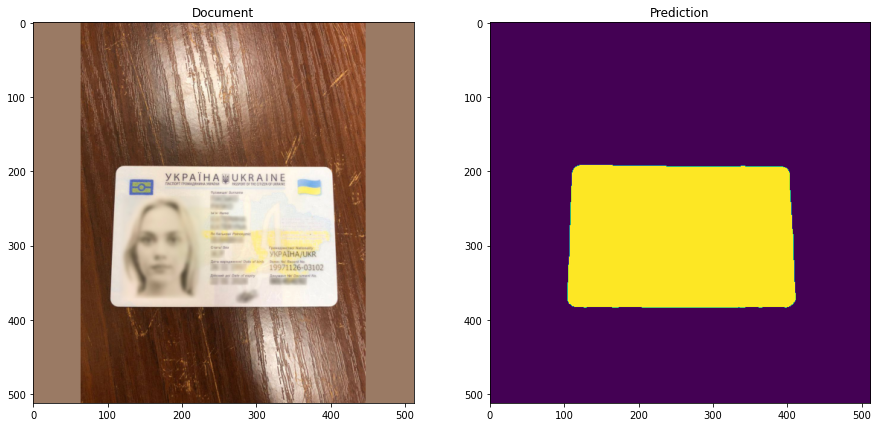

 12%|█▎        | 1/8 [00:01<00:10,  1.48s/it]

2. ratio =  0.563125 , width =  288 , height =  512
1/1 [==============================] - 0s 28ms/step


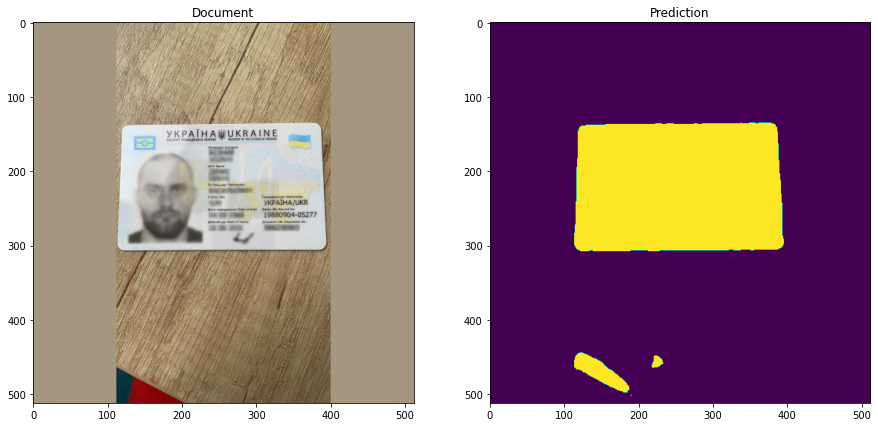

 25%|██▌       | 2/8 [00:02<00:07,  1.22s/it]

2. ratio =  0.75 , width =  384 , height =  512
1/1 [==============================] - 0s 40ms/step


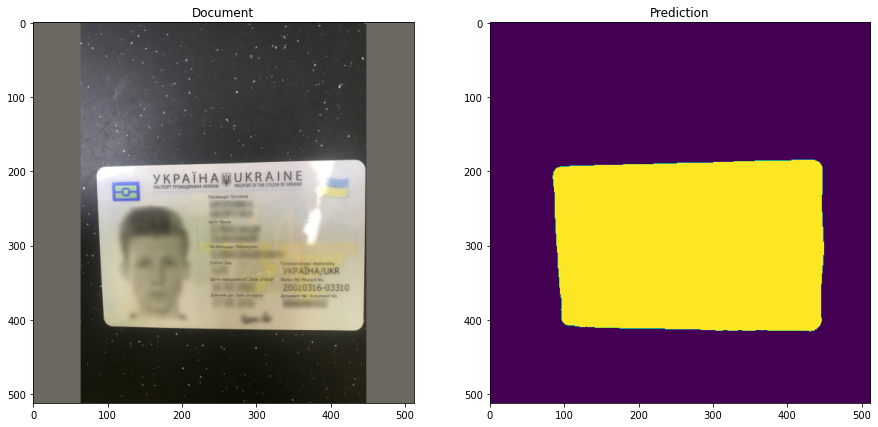

 38%|███▊      | 3/8 [00:03<00:05,  1.18s/it]

2. ratio =  0.75 , width =  384 , height =  512
1/1 [==============================] - 0s 30ms/step


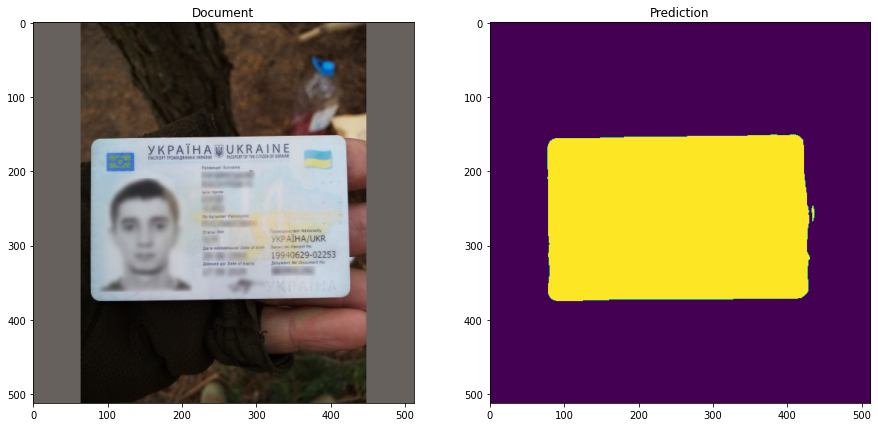

 50%|█████     | 4/8 [00:04<00:04,  1.08s/it]

2. ratio =  0.75 , width =  384 , height =  512
1/1 [==============================] - 0s 34ms/step


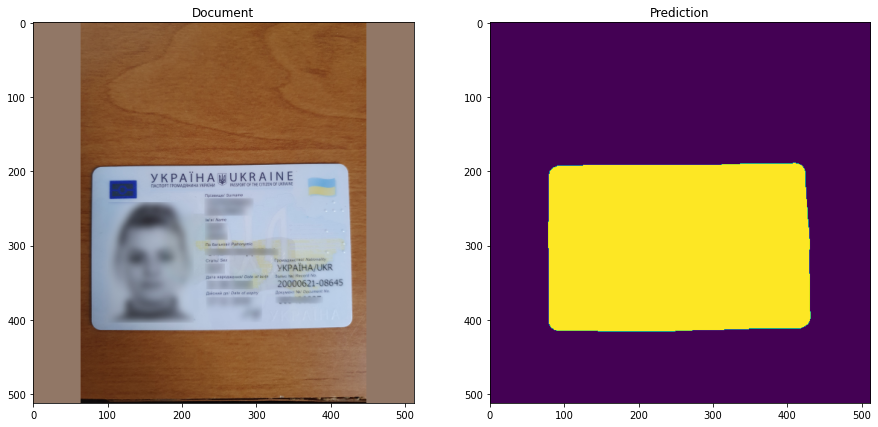

 62%|██████▎   | 5/8 [00:05<00:03,  1.02s/it]

2. ratio =  0.75 , width =  384 , height =  512
1/1 [==============================] - 0s 22ms/step


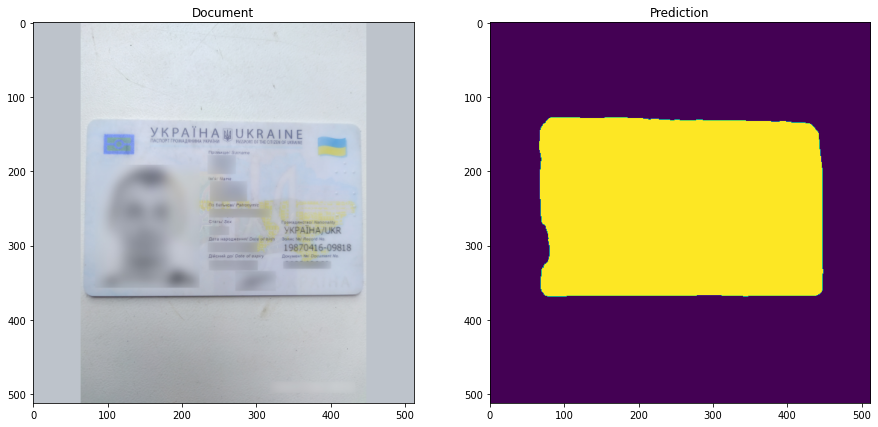

 75%|███████▌  | 6/8 [00:06<00:02,  1.03s/it]

2. ratio =  0.75 , width =  384 , height =  512
1/1 [==============================] - 0s 28ms/step


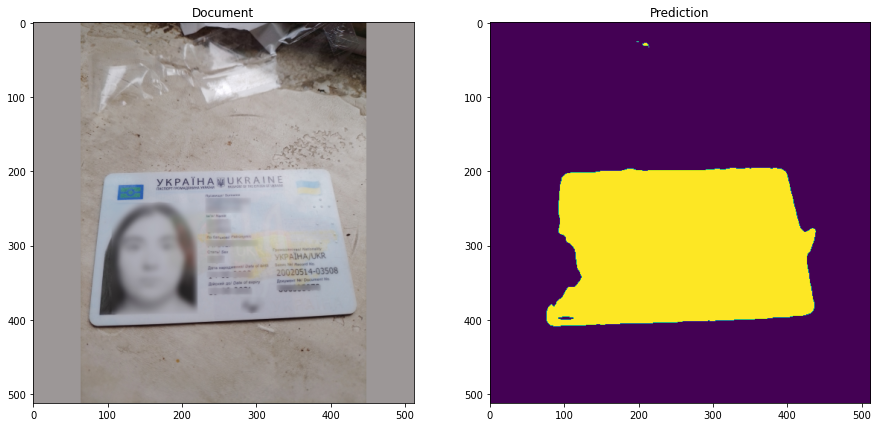

 88%|████████▊ | 7/8 [00:07<00:01,  1.04s/it]

2. ratio =  0.75 , width =  384 , height =  512
1/1 [==============================] - 0s 29ms/step


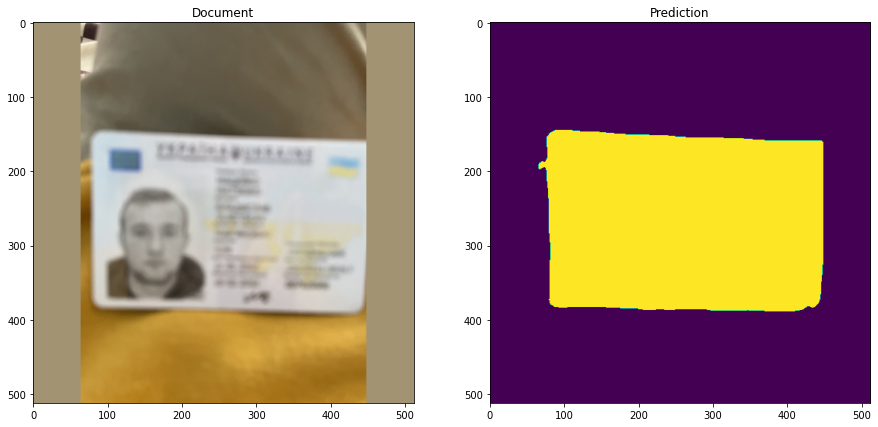

100%|██████████| 8/8 [00:08<00:00,  1.10s/it]


In [ ]:
# @title Evaluate real documents

# Get most used image colors
def get_image_colors(img):
    image = img.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128), interpolation=cv2.INTER_AREA)

    (h, w, c) = img.shape

    img2D = img.reshape(h * w, c)
    kmeans = KMeans(n_clusters=1).fit(img2D)
    colors = kmeans.cluster_centers_.round(0).astype(int)
    
    return colors.tolist()  


# Resize image (adding padding)
def resize_document_image(img, max_image_size = 512):
    height, width = img.shape[:2]

    if width > height:
        ratio = height / width
        width = 512
        height = int(512 * ratio)
        print('1. ratio = ', ratio, ', width = ', width, ', height = ', height)
    else:
        ratio = width / height
        height = 512
        width = int(512 * ratio)
        print('2. ratio = ', ratio, ', width = ', width, ', height = ', height)
        
    img = cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)

    MAX_IMAGE_SIZE = 512
    left = int((max_image_size - width) / 2)
    right = max_image_size - width - left
    top = int((max_image_size - height) / 2)
    bottom = max_image_size - height - top
    
    if left < 0:
        left = 0
    if right < 0:
        right = 0
    if top < 0:
        top = 0
    if bottom < 0:
        bottom = 0

    colors = get_image_colors(img)

    img = cv2.copyMakeBorder(img, top, bottom, left, right, borderType=cv2.BORDER_CONSTANT, value=colors[0])

    return img


# Load model
with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
    model = tf.keras.models.load_model("./files/model.h5")

# Get sorted list of documents
test_x = sorted(glob('/content/datasets/real/*.jpg'))

# Get document image one by one and make prediction
for x in tqdm(zip(test_x), total=len(test_x)):
    image_path = x[0]

    # Reading the image and resize it
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = resize_document_image(image)

    # Normilize data
    x = image / 255.0
    x = np.expand_dims(x, axis=0)

    # Prediction
    y_pred = model.predict(x)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)

    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 13))

    axes[0].imshow(image)
    axes[0].title.set_text('Document')

    axes[1].imshow(y_pred)
    axes[1].title.set_text('Prediction')

    plt.show()
